# Metodología de Control de Calidad e Imputación de Datos de Series de Precipitación In Situ

## Objetivo
Esta metodología tiene como finalidad establecer un proceso robusto para la imputación de datos de precipitación in situ, utilizando técnicas modernas de Big Data y Machine Learning, complementadas con datos satelitales y bases de datos climáticas globales (como CHIRPS, ERA5, entre otras).

## 1. Preprocesamiento y Estandarización de Datos
Antes de aplicar cualquier proceso de control de calidad o imputación, es fundamental garantizar la correcta estructuración de los datos brutos o primarios.

La estructura base de una serie de datos estandarizada será:

| Index       | value |
|-------------|--------|
| 2020-01-01  | 2.53   |

- Index: tipo datetime, correspondiente a la fecha y hora de la observación.

- value: valor numérico registrado (precipitación en mm, por ejemplo).

Esta estructura debe representarse como una `pandas.Series` o un `pandas.DataFrame`, con índice tipo `datetime`.

## 2. Estructura de Control de Calidad
A partir de la serie estandarizada, se genera una estructura de control de calidad que enriquece la serie con metadatos asociados al resultado de las pruebas de calidad:

| Index       | value | qf | dp    |
|-------------|-------|----|-------|
| 2020-01-01  | 2.53  | 1  | 22358 |

- **qf (Quality Flag)**: código numérico que indica el resultado de una o varias pruebas de calidad.

- **dp (Descriptor de Proceso)**: identificador del proceso o técnica aplicada (detección, interpolación, imputación, etc.).

> ⚠️ La preservación de los datos originales es una prioridad. Las modificaciones solo deben aplicarse cuando la prueba indique una necesidad clara y bien justificada.

## 3. Pruebas de Control de Calidad
### 3.1. Consistencia Temporal
Una serie temporal debe tener frecuencia de muestreo constante. Esto significa que cada paso de tiempo entre observaciones debe ser homogéneo (e.g., diaria, horaria).

Proceso:
- Se analiza la frecuencia de muestreo mediante pandas.infer_freq o análisis de diferencias del índice.

- Si se detectan huecos en la serie (días u horas faltantes), se reindexa la serie para completar la malla temporal esperada.

    `df = df.asfreq('D')  # ejemplo para series diarias`
- A los puntos sin datos se les asigna un valor por defecto de -99999, conforme a estándares internacionales como los del IODE (International Oceanographic Data and Information Exchange).
    `df['value'].fillna(-99999, inplace=True)`

### 3.2. Otras Pruebas Básicas
- Rango Físico Aceptable: verifica que los valores estén dentro del rango físico o esperable (e.g., precipitación no puede ser negativa).

- Detección de valores extremos/anómalos: puede utilizarse el IQR, desviaciones estándar, o algoritmos robustos como Isolation Forest.

- Duplicados temporales: detección y resolución de registros con el mismo timestamp.

- Coherencia contextual: análisis de coherencia con estaciones vecinas o datos satelitales.

## 4. Imputación de Datos Faltantes
Una vez aplicada la batería de pruebas de calidad y etiquetados los valores anómalos o faltantes, se procede con la imputación de datos.

### 4.1. Fuentes de Información para la Imputación
- Estaciones vecinas (in situ).

- Datos satelitales (e.g., CHIRPS, GPM).

- Reanálisis climáticos (e.g., ERA5).

- Modelos estadísticos o de machine learning.

### 4.2. Técnicas de Imputación
- Interpolación temporal: lineal, spline, polinómica.

- K-Nearest Neighbors (KNN).

- Modelos de regresión multivariable (MLR).

- Redes neuronales (RNN, LSTM) para imputaciones complejas.

- Random Forest para variables con relaciones no lineales.

- La técnica aplicada se documenta en la columna dp, permitiendo rastrear el origen de cada dato imputado.

## 5. Estándares y Buenas Prácticas
- Trazabilidad: Toda modificación o imputación debe estar documentada y trazable.

- Conservación de Datos Originales: Mantener una copia sin modificar de la serie original.

- Reproducibilidad: Los scripts de calidad deben ser modulares y versionados.

- Evaluación Continua: Los algoritmos de imputación deben ser validados periódicamente frente a nuevas entradas de datos.

```
import pandas as pd

# Serie original
data = {'value': [2.53, 3.0, None, 2.1]}
index = pd.date_range(start='2020-01-01', periods=4, freq='D')
df = pd.DataFrame(data, index=index)

# Estructura de calidad
df['qf'] = [1, 1, 9, 1]  # 9 indica dato faltante
df['dp'] = [22358, 22358, 99999, 22358]
```
7. Resultados Esperados
- Series de precipitación limpias, consistentes, completas y trazables.

- Imputaciones realizadas con soporte técnico y científico.

- Alineación con estándares internacionales (WMO, IODE, etc.).

- Base sólida para análisis hidrometeorológicos, climatológicos o de gestión del recurso hídrico.

# Serie Somo

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.


Reporte de datos NaN por columna:
value    29717
dtype: int64


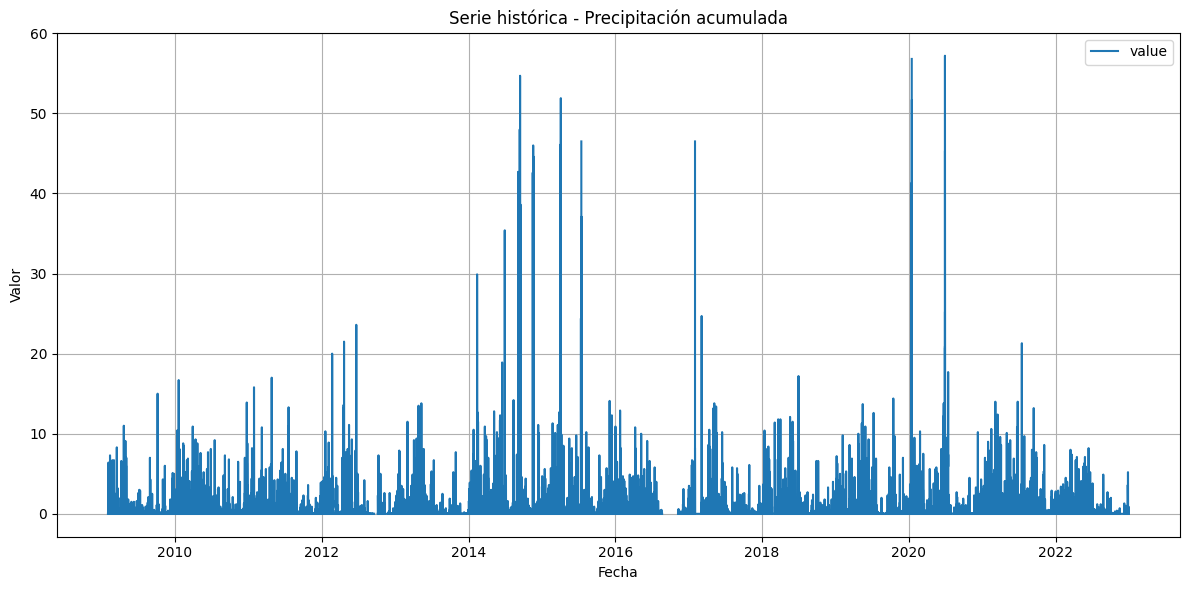

In [3]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    # Asegurar que el índice es datetime
    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    #logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(red_mpomm_serie, label=red_mpomm_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mostrar primeras filas
    red_mpomm_serie

# Serie MSWEB

In [4]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
msweb_serie = pd.read_csv(
    r"D:\master BigData\01 proyecto final\datos\msweb\csv\precipitacion(1.82011, -78.72871).csv",
    parse_dates=['date'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='date'        # establecer la columna como índice
)


# --- Preprocesamiento: Agregacion temporal ---
if not red_mpomm_serie.empty:
    msweb_serie.index= pd.to_datetime(msweb_serie.index)

    # Paso 2: Crear una serie con índice completo con frecuencia cada 3 horas
    start = msweb_serie.index.min()
    end = msweb_serie.index.max()
    full_index = pd.date_range(start=start, end=end, freq='3h')

    # Paso 3: Reindexar para insertar NaN donde faltan datos
    msweb_serie_with_nans = msweb_serie.reindex(full_index)
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(msweb_serie_with_nans, label=msweb_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(msweb_serie_with_nans.isnull().sum())
msweb_serie_with_nans



PermissionError: [Errno 13] Permission denied: 'D:\\master BigData\\01 proyecto final\\datos\\msweb\\csv\\precipitacion(1.82011, -78.72871).csv'

# Seerie IDEAM

Reporte de datos NaN por columna:
Valor    0
dtype: int64


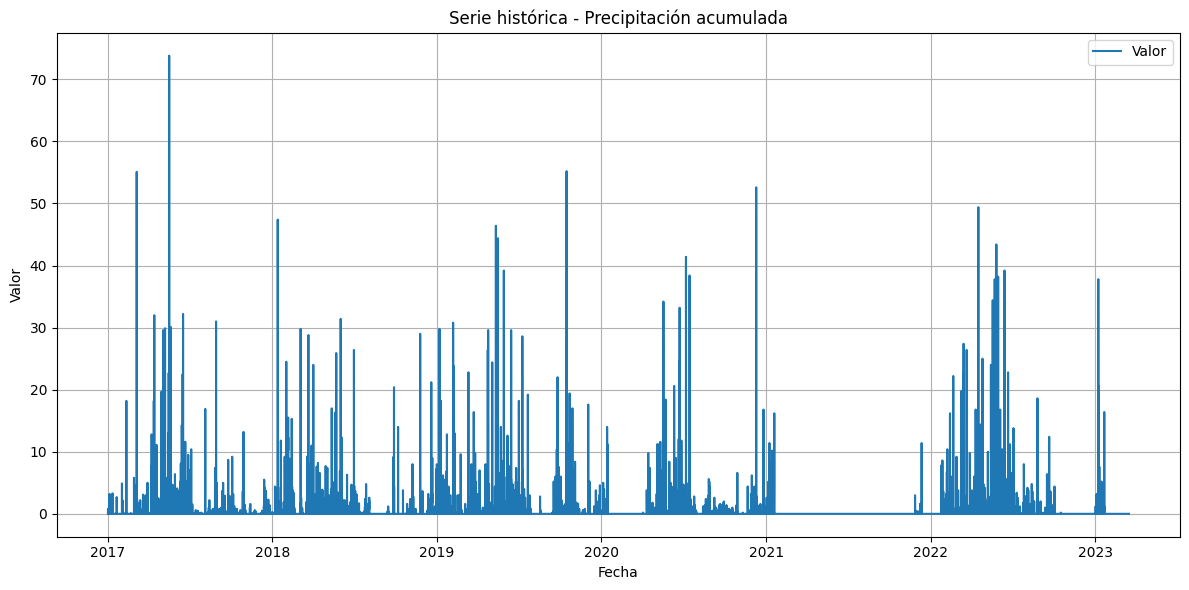

,Valor
Fecha,
2017-01-01 08:00:00,0.0
2017-01-01 09:00:00,0.0
2017-01-01 10:00:00,0.7
2017-01-01 11:00:00,0.0
2017-01-01 12:00:00,0.3
...,...
2023-03-17 01:00:00,0.0
2023-03-17 02:00:00,0.0
2023-03-17 03:00:00,0.0


In [ ]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
ideam_serie = pd.read_csv(
    r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\tumaco_-78,73-1,82.csv",
    parse_dates=['Fecha'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='Fecha'        # establecer la columna como índice
)
ideam_serie = ideam_serie[['Valor']]

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not ideam_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    #ideam_serie.loc[~ideam_serie['qf'].isin([1, 3])] = np.nan
    #ideam_serie = ideam_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(ideam_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(ideam_serie, label=ideam_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

ideam_serie


# Serie Chirps

Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
Reporte de datos NaN por columna:
point_id
point_6    6
dtype: int64


C:\Users\dreng\AppData\Local\Temp\ipykernel_16504\1921895774.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chirps_serie['point_6'] = chirps_serie[chirps_serie['point_6']<=200]


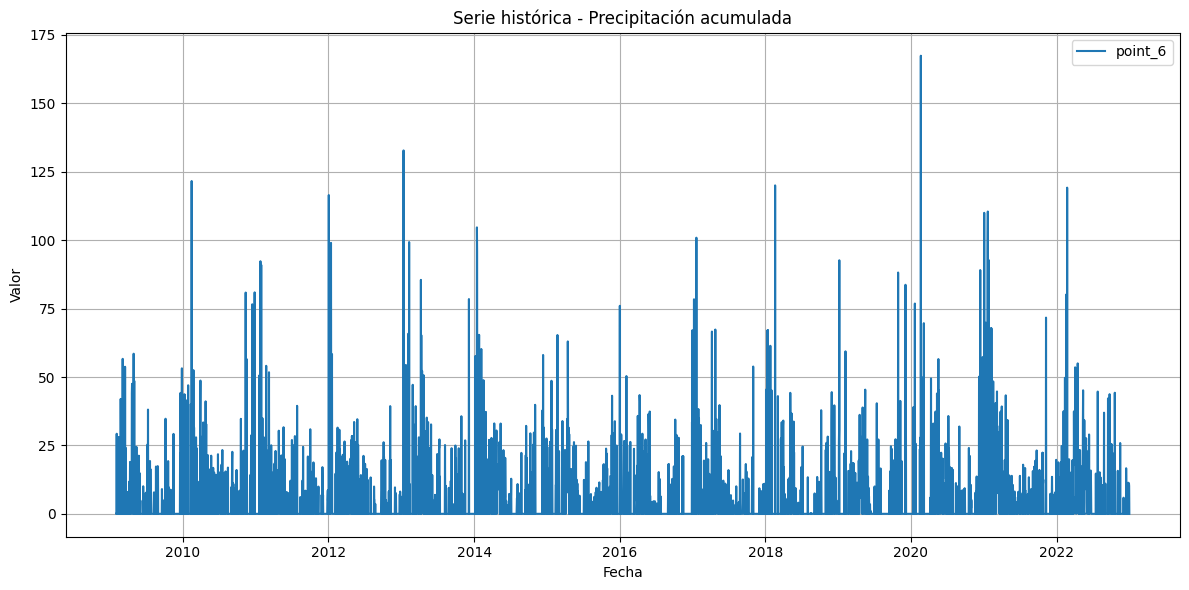

point_id,point_6
timestamp,
2009-02-01,0.000000
2009-02-02,0.000000
2009-02-03,29.260645
2009-02-04,0.000000
2009-02-05,0.000000
...,...
2022-12-28,7.627149
2022-12-29,0.000000
2022-12-30,11.136356


In [ ]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure

try:
    # Conexión a MongoDB
    #print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['tumaco']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        data_mongo_df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in data_mongo_df.columns:
            data_mongo_df = data_mongo_df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        data_mongo_df = data_mongo_df[data_mongo_df['point_id'].isin(selected_points)]
        

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")
    
# Crear la tabla pivotante con fecha como índice y cada punto como columna
series_chirps = data_mongo_df.pivot_table(index='timestamp', columns='point_id', values='value')
series_chirps.index = pd.to_datetime(series_chirps.index)
chirps_serie = series_chirps[['point_6']]

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not chirps_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    #chirps_serie.loc[~chirps_serie['qf'].isin([1, 3])] = np.nan
    #chirps_serie = chirps_serie.drop(columns='qf')
    chirps_serie['point_6'] = chirps_serie[chirps_serie['point_6']<=200]

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(chirps_serie.isnull().sum())
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(chirps_serie, label=chirps_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
chirps_serie